# Import Libraries

In [321]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [322]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [323]:
litecoin_df = pd.read_csv("/content/drive/MyDrive/NN-DL/EXTRA-HW/Litecoin Historical Data - Investing.com.csv")
litecoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1279 non-null   object 
 1   Price     1279 non-null   float64
 2   Open      1279 non-null   float64
 3   High      1279 non-null   float64
 4   Low       1279 non-null   float64
 5   Vol.      1279 non-null   object 
 6   Change %  1279 non-null   object 
dtypes: float64(4), object(3)
memory usage: 70.1+ KB


In [324]:
monero_df = pd.read_csv("/content/drive/MyDrive/NN-DL/EXTRA-HW/Monero Historical Data - Investing.com.csv")
monero_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1851 non-null   object 
 1   Price     1851 non-null   float64
 2   Open      1851 non-null   float64
 3   High      1851 non-null   float64
 4   Low       1851 non-null   float64
 5   Vol.      1851 non-null   object 
 6   Change %  1851 non-null   object 
dtypes: float64(4), object(3)
memory usage: 101.4+ KB


In [325]:
litecoin_df

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 23, 2020",79.706,74.817,79.920,74.722,11.93M,6.53%
1,"Feb 22, 2020",74.818,73.288,76.642,72.422,11.56M,2.08%
2,"Feb 21, 2020",73.291,69.455,75.161,68.633,12.13M,5.52%
3,"Feb 20, 2020",69.455,70.782,72.339,66.495,12.45M,-1.87%
4,"Feb 19, 2020",70.782,77.173,79.041,68.264,12.10M,-8.28%
...,...,...,...,...,...,...,...
1274,"Aug 28, 2016",3.720,3.780,3.780,3.620,8.19K,-1.59%
1275,"Aug 27, 2016",3.780,3.810,3.850,3.620,4.91K,-0.79%
1276,"Aug 26, 2016",3.810,3.810,3.900,3.770,14.35K,0.00%
1277,"Aug 25, 2016",3.810,3.840,3.880,3.750,21.87K,-0.78%


In [326]:
monero_df

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 23, 2020",85.329,79.024,85.541,78.818,271.00K,7.97%
1,"Feb 22, 2020",79.027,80.308,82.896,78.169,277.07K,-1.60%
2,"Feb 21, 2020",80.313,76.355,82.285,75.886,290.15K,5.18%
3,"Feb 20, 2020",76.355,77.843,78.903,75.102,384.42K,-1.91%
4,"Feb 19, 2020",77.843,86.158,86.914,76.718,304.86K,-9.65%
...,...,...,...,...,...,...,...
1846,"Feb 03, 2015",0.331,0.303,0.360,0.302,1.47K,9.31%
1847,"Feb 02, 2015",0.303,0.290,0.303,0.287,0.35K,4.59%
1848,"Feb 01, 2015",0.290,0.290,0.290,0.290,-,0.00%
1849,"Jan 31, 2015",0.290,0.303,0.303,0.290,0.48K,-4.33%


# PreProcess Data

In [327]:
def preprocess_df(df):
    df = df.iloc[::-1].reset_index(drop= True)[df.columns[0:-1]]
    df['Vol.'] = df['Vol.'].replace({'K': '*1e3', 'M': '*1e6', '-':'-1'}, regex=True).map(pd.eval).astype(int)
    return df

litecoin_df = preprocess_df(litecoin_df)
monero_df = preprocess_df(monero_df)


## Normalization

In [328]:
class Normalizer():
    def __init__(self, df):
        self.df = df
        self.scaler = MinMaxScaler()
        self.normalized_df = None

    def normalize(self):
        self.scaler.fit(self.df)
        normalized_data = self.scaler.transform(self.df)
        self.normalized_df = pd.DataFrame(normalized_data, columns=["Price"])
        return self.normalized_df


In [329]:
litecoin_df_price = litecoin_df[["Price"]]
monero_df_price = monero_df[["Price"]]

In [330]:
litecoin_normalizer = Normalizer(litecoin_df[["Price"]])
monero_normalizer = Normalizer(monero_df[["Price"]])

litecoin_df_normal = litecoin_normalizer.normalize()
monero_df_normal = monero_normalizer.normalize()


In [331]:
target_col = 'Price'

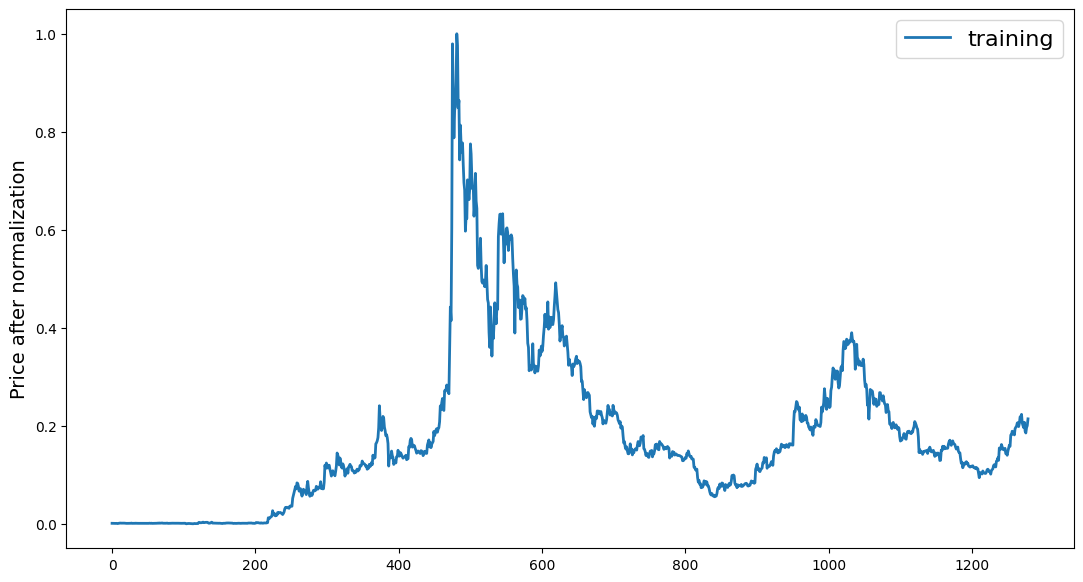

In [332]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)

    if line2 != None:
        ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price after normalization', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

line_plot(litecoin_df_normal[target_col],None , 'training', 'test', title='')

## Generate Train and Test Data

In [353]:
def generate_data(df, col_name, pred_window_size , window_size=30):
    row_data  = np.array(df[col_name])
    x = []
    y =  []
    for i in range(len(row_data)-window_size):
        x.append(row_data[i:i+window_size])
        y.append(row_data[i+window_size - pred_window_size:i+window_size ])
    return np.array(x)[...,np.newaxis], np.array(y)#[...,np.newaxis]

In [375]:
PRED_WINDOW = 7
# x, y = generate_data(monero_df_normal, 'Price', pred_window_size =  PRED_WINDOW)
# x.shape,y.shape

x, y = generate_data(litecoin_df_normal, 'Price', pred_window_size =  PRED_WINDOW)
x.shape,y.shape


((1249, 30, 1), (1249, 7))

In [376]:
class TrainTestSplit:
    def __init__(self,x,y,n_day_prediction):
        self.x  = x
        self.y  = y
        self.n_day = n_day_prediction

    def apply_split(self):
        x_train , y_train = self.x[:-self.n_day],  self.y[:-self.n_day]
        x_test, y_test = self.x[-self.n_day:],  self.y[-self.n_day:]
        return x_train, y_train , x_test, y_test
    
train_test_spliter = TrainTestSplit(x, y, 7)
x_train, y_train, x_test, y_test = train_test_spliter.apply_split()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1242, 30, 1), (1242, 7), (7, 30, 1), (7, 7))

In [377]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_train.size(),x_train.size()

(torch.Size([1242, 7]), torch.Size([1242, 30, 1]))

# Model

## Model Architecture

In [381]:
import torch
import torch.nn as nn

class LSTMmodel(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size, dropout):
        super(LSTMmodel, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers =  num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size =self.input_size , hidden_size = self.hidden_dim, num_layers = num_layers, dropout =self.dropout, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim , self.output_size)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm1(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
       
        return out


class LSTMGRUHYBRID(nn.Module):
    def __init__(self, input_size, hidden_dims, num_layers, output_size, dropout = 0.3):
        super(LSTMGRUHYBRID, self).__init__()
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.num_layers =  num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size = self.input_size , hidden_size = self.hidden_dims[0], num_layers = self.num_layers , dropout = self.dropout, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = self.hidden_dims[0], hidden_size =self.hidden_dims[1], num_layers = self.num_layers, dropout = self.dropout, batch_first=True)
        self.gru = nn.GRU(input_size = self.input_size, hidden_size = self.hidden_dims[0] , num_layers = self.num_layers , dropout = .3, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_dims[1], 30)
        self.fc2 = nn.Linear(self.hidden_dims[0], 30)
        self.fc3 = nn.Linear(60, self.output_size)

    def lstm_path(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dims[0]).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dims[0]).requires_grad_()
        out, _ = self.lstm1(x, (h0.detach(), c0.detach()))
        out, _ = self.lstm2(out)
        out  = self.fc1(out[:,-1,:])
        return out

    def gru_path(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dims[0]).requires_grad_()
        out, _ = self.gru(x, (h0.detach()))
        out  = self.fc2(out[:,-1,:])
        return out

    def forward(self,x):
        out1 = self.lstm_path(x)
        out2 = self.gru_path(x)
        out = torch.cat((out1, out2), dim=1)
        out = self.fc3(out)
        #print(out.shape)
        return out

In [382]:
lstm_model =  LSTMmodel(input_size=1, hidden_dim=30, num_layers=1, output_size=PRED_WINDOW, dropout=.2)
hybrid_model = LSTMGRUHYBRID(input_size=1, hidden_dims=[30,50], num_layers=1, output_size=PRED_WINDOW, dropout=0.2)

In [383]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cpu


In [384]:
lstm_model.to(DEVICE)
hybrid_model.to(DEVICE)

LSTMGRUHYBRID(
  (lstm1): LSTM(1, 30, batch_first=True, dropout=0.2)
  (lstm2): LSTM(30, 50, batch_first=True, dropout=0.2)
  (gru): GRU(1, 30, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=50, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=60, out_features=7, bias=True)
)

## Utils

In [387]:
def cost_loss_plot(y1, y2, title):
    plt.plot( y1, label ='Lstm')
    plt.plot( y2, '-.', label ='hybrid')

    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.title(title)
    plt.show()

In [388]:
def train_model(model, x_train = x_train, y_train = y_train):
    num_epochs = 100
    loss_mse = torch.nn.MSELoss()
    loss_mae = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    hist_mae = np.zeros(num_epochs)
    hist_mse = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()
        
        # Forward pass
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        y_pred = model(x_train)
        mse = loss_mse(y_pred, y_train)
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", mse.item())
        hist_mse[t] = mse.item()
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        #mae.backward()
        mse.backward()
        mae = loss_mae(y_pred, y_train)
        hist_mae[t] = mae.item()
        # Update parameters
        optimiser.step()

    return hist_mae, hist_mse

## Train Models

In [389]:
hist_mae_lstm, hist_mse_lstm = train_model(lstm_model)


Epoch  10 MSE:  0.05714944750070572
Epoch  20 MSE:  0.04393821209669113
Epoch  30 MSE:  0.03244069218635559
Epoch  40 MSE:  0.022783339023590088
Epoch  50 MSE:  0.01545154582709074
Epoch  60 MSE:  0.006071553565561771
Epoch  70 MSE:  0.004520930349826813
Epoch  80 MSE:  0.0028583446983247995
Epoch  90 MSE:  0.00226450408808887


In [390]:
hist_mae_hyb, hist_mse_hyb = train_model(hybrid_model)

Epoch  10 MSE:  0.0333571583032608
Epoch  20 MSE:  0.02765771932899952
Epoch  30 MSE:  0.02433793805539608
Epoch  40 MSE:  0.021802084520459175
Epoch  50 MSE:  0.015948839485645294
Epoch  60 MSE:  0.003908110316842794
Epoch  70 MSE:  0.002258086111396551
Epoch  80 MSE:  0.0015092316316440701
Epoch  90 MSE:  0.0010976826306432486


## Litecoin Train Loss

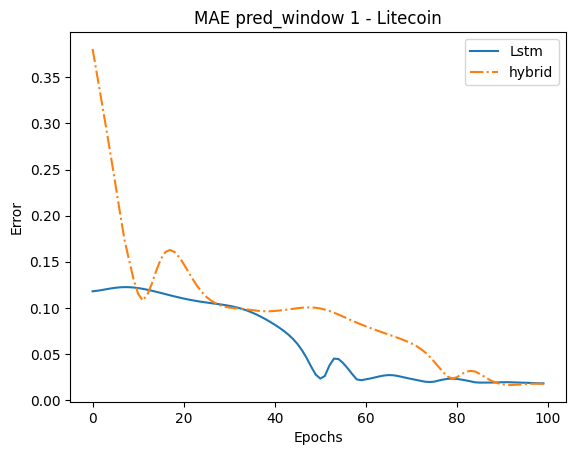

In [348]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 1 - Litecoin")

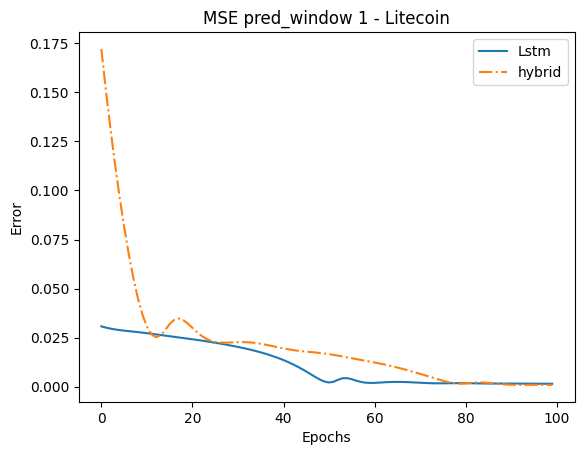

In [349]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 1 - Litecoin")

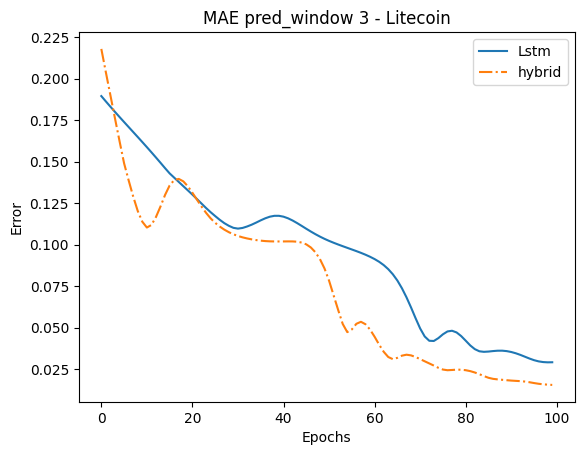

In [371]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 3 - Litecoin")

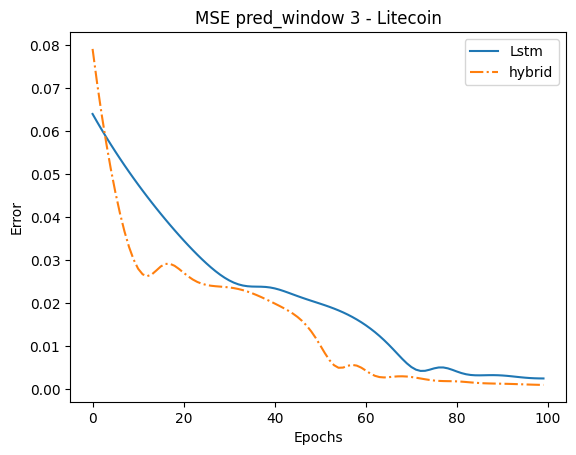

In [372]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 3 - Litecoin")

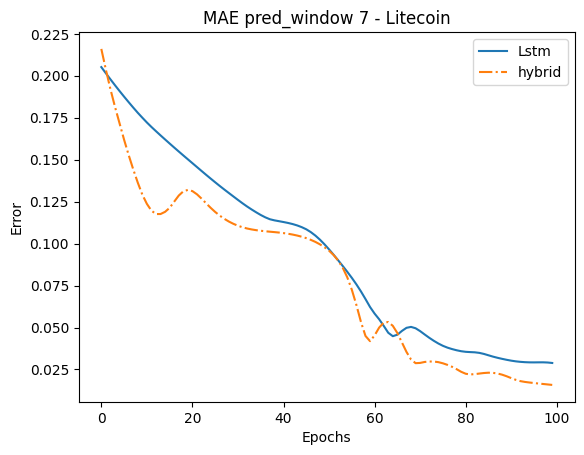

In [391]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 7 - Litecoin")

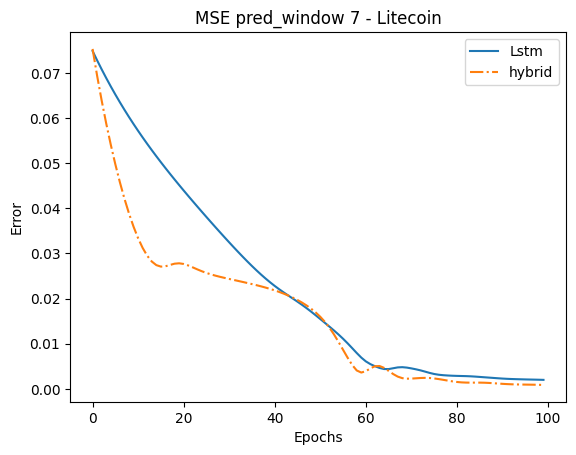

In [392]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 7 - Litecoin")

## Monero Train Loss

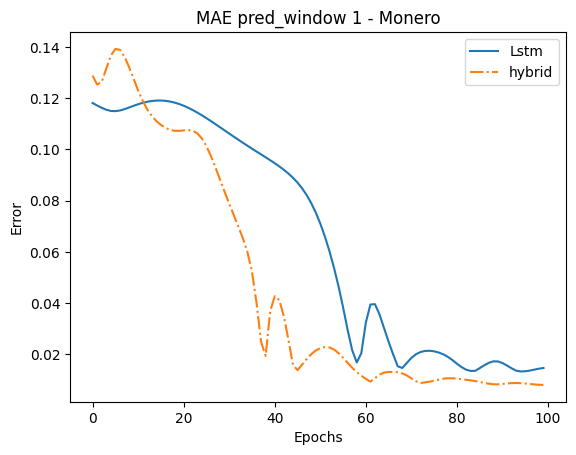

In [294]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 1 - Monero")

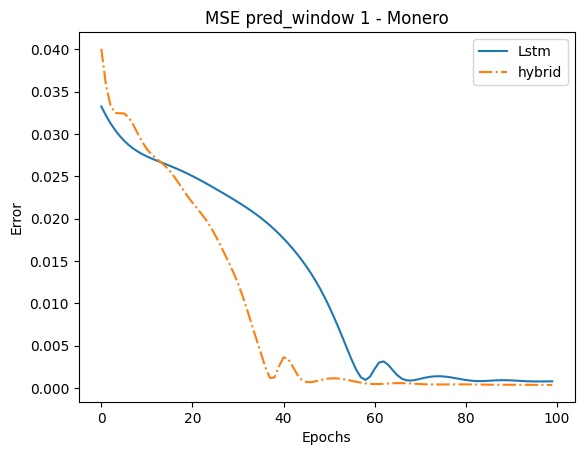

In [295]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 1 - Monero")

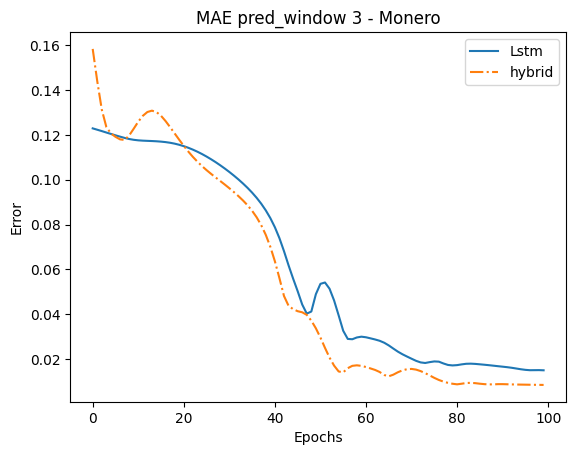

In [317]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 3 - Monero")

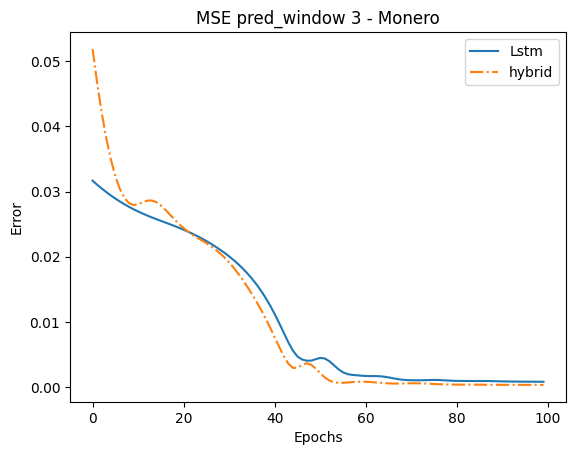

In [318]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 3 - Monero")

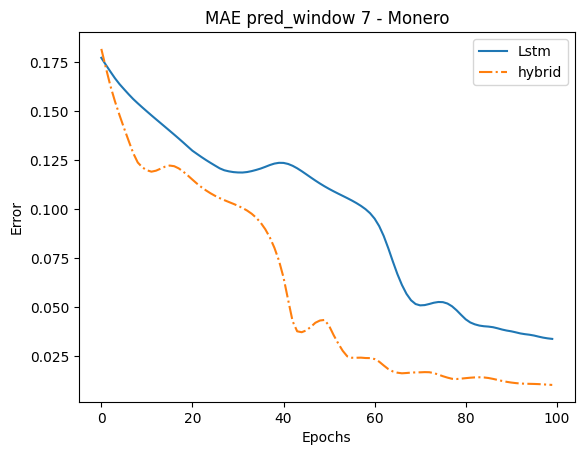

In [236]:
cost_loss_plot(hist_mae_lstm,hist_mae_hyb, "MAE pred_window 7 - Monero")

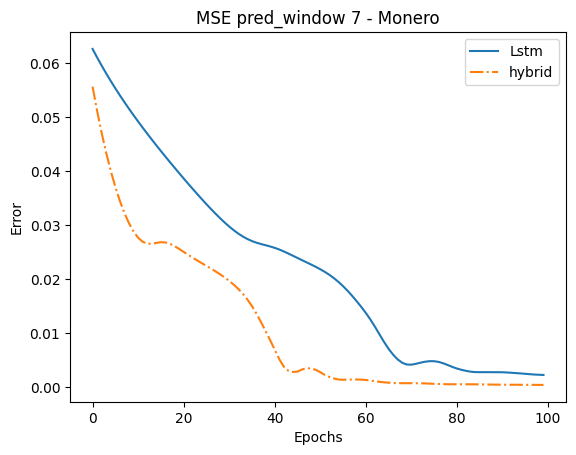

In [237]:
cost_loss_plot(hist_mse_lstm,hist_mse_hyb, "MSE pred_window 7 - Monero")

# Model Errors and Result

## LSTM Model 

In [393]:
# make predictions
y_test_pred = lstm_model(x_test)
y_train_pred = lstm_model(x_train)
# invert predictions
y_train_pred_transform = monero_normalizer.scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_transform = monero_normalizer.scaler.inverse_transform(y_train)
y_test_pred_transform = monero_normalizer.scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_transform = monero_normalizer.scaler.inverse_transform(y_test)

train_mse = math.sqrt(mean_squared_error(y_train_transform[:,:], y_train_pred_transform[:,:]))
print('Train MSE: %.2f ' % (train_mse))
print('Train RMSE: %.2f ' % math.sqrt(train_mse))
test_mse = math.sqrt(mean_squared_error(y_test_transform[:,:], y_test_pred_transform[:,:]))
# print('Test MSE: %.2f RMSE' % (test_mse))
# print('Test RMSE: %.2f RMSE' % math.sqrt(test_mse))

train_mae  = mean_absolute_error(y_train_transform, y_train_pred_transform)
test_mae = mean_absolute_error(y_test_transform, y_test_pred_transform)
print('Train MAE: %.2f ' %(train_mae))
# print('Test MAE: %.2f RMSE' %(test_mae))
train_mape  = mean_absolute_percentage_error(y_train_transform.flatten(), y_train_pred_transform.flatten())
test_mape = mean_absolute_percentage_error(y_test_transform.flatten(), y_test_pred_transform.flatten())
print('Train MAPE: %.2f' %(train_mape))
# print('Test MAPE: %.2f RMSE' %(test_mape))




Train MSE: 20.94 
Train RMSE: 4.58 
Train MAE: 13.51 
Train MAPE: 5.42


## Hybrid Model

In [394]:
y_test_pred = hybrid_model(x_test)
y_train_pred = hybrid_model(x_train)
# invert predictions
y_train_pred_transform = monero_normalizer.scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_transform = monero_normalizer.scaler.inverse_transform(y_train)
y_test_pred_transform = monero_normalizer.scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_transform = monero_normalizer.scaler.inverse_transform(y_test)

train_mse = math.sqrt(mean_squared_error(y_train_transform[:,:], y_train_pred_transform[:,:]))
print('Train MSE: %.2f ' % (train_mse))
print('Train RMSE: %.2f' % math.sqrt(train_mse))
test_mse = math.sqrt(mean_squared_error(y_test_transform[:,:], y_test_pred_transform[:,:]))
# print('Test MSE: %.2f RMSE' % (test_mse))
# print('Test RMSE: %.2f RMSE' % math.sqrt(test_mse))


train_mae  = mean_absolute_error(y_train_transform, y_train_pred_transform)
test_mae = mean_absolute_error(y_test_transform, y_test_pred_transform)
print('Train MAE: %.2f ' %(train_mae))
# print('Test MAE: %.2f RMSE' %(test_mae))

train_mape  = mean_absolute_percentage_error(y_train_transform.flatten(), y_train_pred_transform.flatten())
test_mape = mean_absolute_percentage_error(y_test_transform.flatten(), y_test_pred_transform.flatten())
print('Train MAPE: %.2f' %(train_mape))
# print('Test MAPE: %.2f RMSE' %(test_mape))


Train MSE: 13.69 
Train RMSE: 3.70
Train MAE: 7.35 
Train MAPE: 2.52
